In [1]:
from google.cloud import bigquery
import pandas as pd

In [2]:
#Does this work for storing git credentials?
#Yes.
#!git config --global credential.helper store

In [3]:
client = bigquery.Client(location=" europe-west2")
print("Client creating using default project: {}".format(client.project))

Client creating using default project: ons-luda-analysis-prod


In [4]:
query = """
    SELECT AREACD, Indicator, Category, Value 
    FROM `ons-luda-data-prod.ingest_luda.20220201_subnational_indicators_explorer_p` 
    
"""
query_job = client.query(
    query,
    # Location must match that of the dataset(s) referenced in the query.
    location="europe-west2",
)  # API request - starts the query

all_metrics = query_job.to_dataframe()
all_metrics

,AREACD,Indicator,Category,Value
0,E10000008,Male healthy life expectancy,Spreading opportunity and improving public ser...,67.790000
1,E10000030,Male healthy life expectancy,Spreading opportunity and improving public ser...,67.210000
2,E10000006,Male healthy life expectancy,Spreading opportunity and improving public ser...,62.920000
3,E10000013,Male healthy life expectancy,Spreading opportunity and improving public ser...,68.240000
4,E10000015,Male healthy life expectancy,Spreading opportunity and improving public ser...,67.000000
...,...,...,...,...
7640,E07000041,Average travel time to nearest large employmen...,Boosting Living Standards,10.594670
7641,E07000080,Average travel time to nearest large employmen...,Boosting Living Standards,20.818368
7642,E06000009,Average travel time to nearest large employmen...,Boosting Living Standards,8.375514
7643,E06000032,Average travel time to nearest large employmen...,Boosting Living Standards,8.676515


In [5]:
metrics_wide = pd.pivot(all_metrics, values='Value', columns='Indicator', index='AREACD').reindex()
metrics_wide

Indicator,4G coverage provided by at least one mobile network provider,5 year olds achieving 'expected level' on communication early learning goals,5 year olds achieving 'expected level' on literacy early learning goals,5 year olds achieving 'expected level' on maths early learning goals,Adult (18+) overweight and obesity prevalance,Adults that currently smoke cigarettes,Average anxiety rating,Average feeling that things done in life are worthwhile rating,Average happiness rating,Average life satisfaction rating,...,Female healthy life expectancy,Gross Value Added per hour worked,Gross median weekly pay,Male healthy life expectancy,Net additions to the housing stock,Number of completions on apprenticeships,Number of starts on apprenticeships,Premises with gigabit capable broadband,Schools and nurseries rated good or outstanding by OFSTED,Young people achieving GCSEs (and equivalent qualifications) in English and Maths by age 19
AREACD,,,,,,,,,,,,,,,,,,,,,
E06000001,99.92,79.3,73.5,76.9,73.023122,15.9,3.39,7.68,7.21,7.33,...,57.39,28.31,487.4,57.03,161.0,370.0,660.0,5.3,86.842105,67.584098
E06000002,100.00,71.8,63.9,68.2,71.734626,12.8,3.11,7.62,7.26,7.21,...,58.52,29.30,420.8,58.53,456.0,470.0,900.0,5.6,85.454545,63.192420
E06000003,99.33,79.9,72.2,77.6,72.878500,13.4,3.16,7.76,7.49,7.44,...,60.34,26.54,439.2,60.23,365.0,560.0,980.0,1.5,79.310345,69.636136
E06000004,99.99,84.4,74.6,79.9,66.993264,10.8,3.25,7.74,7.25,7.40,...,56.84,34.37,469.4,57.79,616.0,740.0,1400.0,5.7,94.871795,69.495055
E06000005,100.00,78.1,73.2,77.1,63.811596,13.5,3.63,7.55,7.12,7.25,...,62.16,32.68,486.7,58.09,542.0,390.0,730.0,2.9,78.571429,67.890772
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
W06000020,98.32,NaN,NaN,NaN,NaN,12.9,3.46,7.66,7.26,7.34,...,57.79,28.34,476.2,59.65,NaN,NaN,NaN,12.1,NaN,NaN
W06000021,92.66,NaN,NaN,NaN,NaN,7.1,3.19,7.80,7.65,7.59,...,66.14,29.47,602.8,66.36,NaN,NaN,NaN,11.6,NaN,NaN
W06000022,100.00,NaN,NaN,NaN,NaN,18.7,3.40,7.63,7.35,7.28,...,59.48,30.37,473.4,57.96,NaN,NaN,NaN,9.1,NaN,NaN


In [6]:
corr = metrics_wide.corr()
corr.style.background_gradient(cmap='rainbow')

Indicator,4G coverage provided by at least one mobile network provider,5 year olds achieving 'expected level' on communication early learning goals,5 year olds achieving 'expected level' on literacy early learning goals,5 year olds achieving 'expected level' on maths early learning goals,Adult (18+) overweight and obesity prevalance,Adults that currently smoke cigarettes,Average anxiety rating,Average feeling that things done in life are worthwhile rating,Average happiness rating,Average life satisfaction rating,Average travel time to nearest large employment centre (500+ employees) by bike,Average travel time to nearest large employment centre (500+ employees) by car,Average travel time to nearest large employment centre (500+ employees) by public transport or walking,Children (4 to 5 years old) overweight and obesity prevalance,Employment rate for 16 to 64 year olds,Female healthy life expectancy,Gross Value Added per hour worked,Gross median weekly pay,Male healthy life expectancy,Net additions to the housing stock,Number of completions on apprenticeships,Number of starts on apprenticeships,Premises with gigabit capable broadband,Schools and nurseries rated good or outstanding by OFSTED,Young people achieving GCSEs (and equivalent qualifications) in English and Maths by age 19
Indicator,,,,,,,,,,,,,,,,,,,,,,,,,
4G coverage provided by at least one mobile network provider,1.000000,-0.127658,-0.045609,-0.071449,0.041198,0.021778,0.133767,-0.173055,-0.141203,-0.149987,-0.313623,-0.158601,-0.385191,-0.128582,0.051151,-0.147801,0.222618,0.203054,-0.097786,0.104493,-0.023539,-0.003825,0.201884,0.082525,-0.099043
5 year olds achieving 'expected level' on communication early learning goals,-0.127658,1.000000,0.831856,0.883443,-0.347917,-0.468850,-0.053471,0.025685,0.103706,0.202815,0.344772,0.362432,0.299504,-0.502601,0.520549,0.517988,0.280187,0.364282,0.604239,-0.077419,-0.168895,-0.180747,-0.021026,0.301009,0.554165
5 year olds achieving 'expected level' on literacy early learning goals,-0.045609,0.831856,1.000000,0.963398,-0.456464,-0.503795,-0.079938,0.047791,0.217968,0.250403,0.308538,0.361257,0.241779,-0.574341,0.478154,0.582436,0.435106,0.592733,0.593684,-0.090367,-0.369707,-0.342633,0.123600,0.509152,0.686668
5 year olds achieving 'expected level' on maths early learning goals,-0.071449,0.883443,0.963398,1.000000,-0.471949,-0.534319,-0.056788,0.060468,0.207393,0.264480,0.316133,0.351638,0.253372,-0.572009,0.552996,0.637929,0.405930,0.553957,0.664319,-0.082852,-0.320671,-0.307412,0.075959,0.455179,0.684990
Adult (18+) overweight and obesity prevalance,0.041198,-0.347917,-0.456464,-0.471949,1.000000,0.267221,-0.130716,0.018245,0.017412,0.005742,0.055031,-0.025102,0.094527,0.426691,-0.242971,-0.444596,-0.336306,-0.543611,-0.453743,-0.135292,0.211096,0.160652,-0.238854,-0.518199,-0.470597
Adults that currently smoke cigarettes,0.021778,-0.468850,-0.503795,-0.534319,0.267221,1.000000,0.067513,-0.110486,-0.185231,-0.226681,-0.136636,-0.132296,-0.163080,0.380645,-0.273094,-0.478568,-0.126731,-0.201012,-0.543433,0.034693,0.151390,0.153942,0.036315,-0.237065,-0.447291
Average anxiety rating,0.133767,-0.053471,-0.079938,-0.056788,-0.130716,0.067513,1.000000,-0.395677,-0.605410,-0.427245,-0.299838,-0.287474,-0.313430,-0.043563,-0.126064,-0.172153,0.125309,0.087893,-0.179014,0.101718,0.059389,0.076243,0.142697,0.247657,-0.114863
Average feeling that things done in life are worthwhile rating,-0.173055,0.025685,0.047791,0.060468,0.018245,-0.110486,-0.395677,1.000000,0.631842,0.717736,0.362933,0.354760,0.347375,-0.009882,0.085366,0.185586,-0.111042,-0.145142,0.227663,-0.149938,-0.131973,-0.167130,-0.224264,-0.237194,0.158461
Average happiness rating,-0.141203,0.103706,0.217968,0.207393,0.017412,-0.185231,-0.605410,0.631842,1.000000,0.698340,0.347668,0.341539,0.347143,-0.103188,0.099919,0.312700,-0.081789,-0.086856,0.293941,-0.089847,-0.141101,-0.158168,-0.230510,-0.036698,0.194137


<AxesSubplot:xlabel="5 year olds achieving 'expected level' on communication early learning goals", ylabel="5 year olds achieving 'expected level' on maths early learning goals">

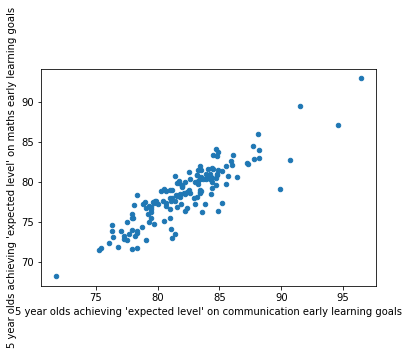

In [7]:
metrics_wide.plot.scatter(x="5 year olds achieving 'expected level' on communication early learning goals",
                          y="5 year olds achieving 'expected level' on maths early learning goals")

array([[<AxesSubplot:title={'center':'Male healthy life expectancy'}>]],
      dtype=object)

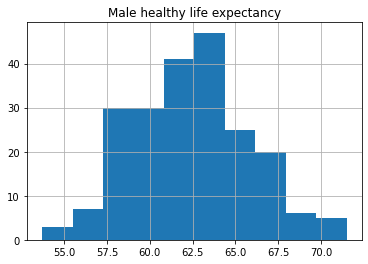

In [24]:
metrics_wide.hist("Male healthy life expectancy")

In [17]:
##Subset by category
living_standards = all_metrics[all_metrics['Category'].str.contains('Living Standards')]
living_standards = pd.pivot_table(living_standards, values='Value', columns='Indicator', index='AREACD').reindex()

spreading_opp = all_metrics[all_metrics['Category'].str.contains('opportunity')]
spreading_opp = pd.pivot_table(spreading_opp, values='Value', columns='Indicator', index='AREACD').reindex()

local_pride = all_metrics[all_metrics['Category'].str.contains('local pride')]
local_pride = pd.pivot_table(local_pride, values='Value', columns='Indicator', index='AREACD').reindex()


In [29]:
#Need to remove NaN values.
liv_reduced = living_standards[living_standards.notna().all(axis=1)]
loc_reduced = local_pride[local_pride.notna().all(axis=1)]
opp_reduced = spreading_opp[spreading_opp.notna().all(axis=1)]

#Then we can do scaling and then run a k-means
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
liv_scaled = scaler.fit_transform(liv_reduced)
loc_scaled = scaler.fit_transform(loc_reduced)
opp_scaled = scaler.fit_transform(opp_reduced)

In [104]:
#Do the clustering. Here assume it's reasonable-ish to cluster into 3 (high/med/low)
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, n_init=10, max_iter=300)

kmeans.fit(liv_reduced)
liv_clusters = pd.DataFrame(liv_reduced.reset_index()['AREACD'])
liv_clusters['Cluster'] = kmeans.labels_

kmeans.fit(loc_reduced)
loc_clusters = pd.DataFrame(loc_reduced.reset_index()['AREACD'])
loc_clusters['Cluster'] = kmeans.labels_

kmeans.fit(opp_reduced)
opp_clusters = pd.DataFrame(opp_reduced.reset_index()['AREACD'])
opp_clusters['Cluster'] = kmeans.labels_

In [105]:
#Get geospatial data via a query.
import geopandas

query = """
    SELECT LAD20CD, geom, BNG_E, BNG_N
    FROM `ons-luda-data-prod.ingest_geography.ltla_uk_2020_bqg_v1`
    
"""
query_job = client.query(
    query,
    # Location must match that of the dataset(s) referenced in the query.
    location="europe-west2",
)  # API request - starts the query

la_geo = query_job.to_geodataframe
la_geo()

,LAD20CD,geom,BNG_E,BNG_N
0,E08000004,"POLYGON ((-2.02304 53.61582, -2.02682 53.62415...",396603,406784
1,E07000137,"POLYGON ((0.24455 53.04859, 0.23604 53.05303, ...",534861,376064
2,E06000018,"POLYGON ((-1.12011 52.96781, -1.12279 52.98345...",456082,339969
3,E07000077,"POLYGON ((0.34593 52.04971, 0.32464 52.07277, ...",557832,228865
4,E07000192,"POLYGON ((-1.95926 52.68413, -1.91552 52.71062...",401261,311553
...,...,...,...,...
374,E07000196,"POLYGON ((-2.04341 52.76133, -2.07617 52.76695...",389625,311037
375,S12000013,"MULTIPOLYGON (((-6.84185 58.19682, -6.84769 58...",126473,932862
376,E07000211,"POLYGON ((-0.19734 51.34360, -0.22097 51.32986...",525786,152574
377,E06000023,"MULTIPOLYGON (((-2.73052 51.50227, -2.73259 51...",359990,174846


In [106]:
#This is a bit messy, had to do it backwards as la_geo is a GEO_dataframe, others are regular dataframes.
#So changed order and did right <-> left
opp_clusters = la_geo().merge(opp_clusters, right_on = 'AREACD', left_on = 'LAD20CD', how='right')
liv_clusters = la_geo().merge(liv_clusters, right_on = 'AREACD', left_on = 'LAD20CD', how='right')
loc_clusters = la_geo().merge(loc_clusters, right_on = 'AREACD', left_on = 'LAD20CD', how='right')


In [86]:
#Plotting. Test out package installs.
#This says it's already installed.
#!pip install geopandas

<AxesSubplot:>

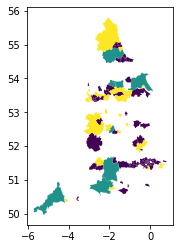

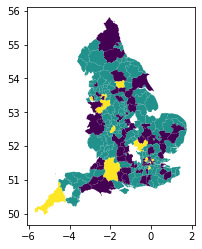

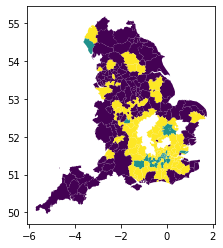

In [115]:
opp_clusters.plot(column = "Cluster")
loc_clusters.plot(column = "Cluster")
liv_clusters.plot(column = "Cluster")